<a href="https://colab.research.google.com/github/lsaif/SyntheticDT/blob/master/synDT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Authenticate to access Google Drive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

###Import supporting libraries

In [0]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler, label_binarize
import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms

from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR

np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

device = 'cpu'#torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Using device: cpu


###Data Loading

In [0]:
def LoadData(url,filename):
  fluff, id = url.split('=')
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(filename)
  return filename

LoadData(url="https://drive.google.com/open?id=1loA7lg3_FHVnqa0a2l3mpKkOlcvxtwvH", filename="synDT.csv")
dset = pd.read_csv("synDT.csv", sep=',').set_index('SOURCE_WELL')
print(dset.head(5))
dset = dset.dropna()

                   GR      NPHI      RHOB    ILD    PROX       DT  SOURCE_REF
SOURCE_WELL                                                                  
JTB-047      141.2922  0.162693  2318.512  3.805  14.795  247.469   2140.0008
JTB-047      142.7190  0.157127  2328.154  4.287  24.338  251.261   2140.1532
JTB-047      144.7218  0.152266  2331.870  5.099  23.816  252.945   2140.3056
JTB-047      145.0291  0.149034  2349.075  5.398  23.440  247.567   2140.4580
JTB-047      143.7977  0.152346  2369.614  5.745  17.720  238.159   2140.6104


###Data Preprocessing

####Visualization

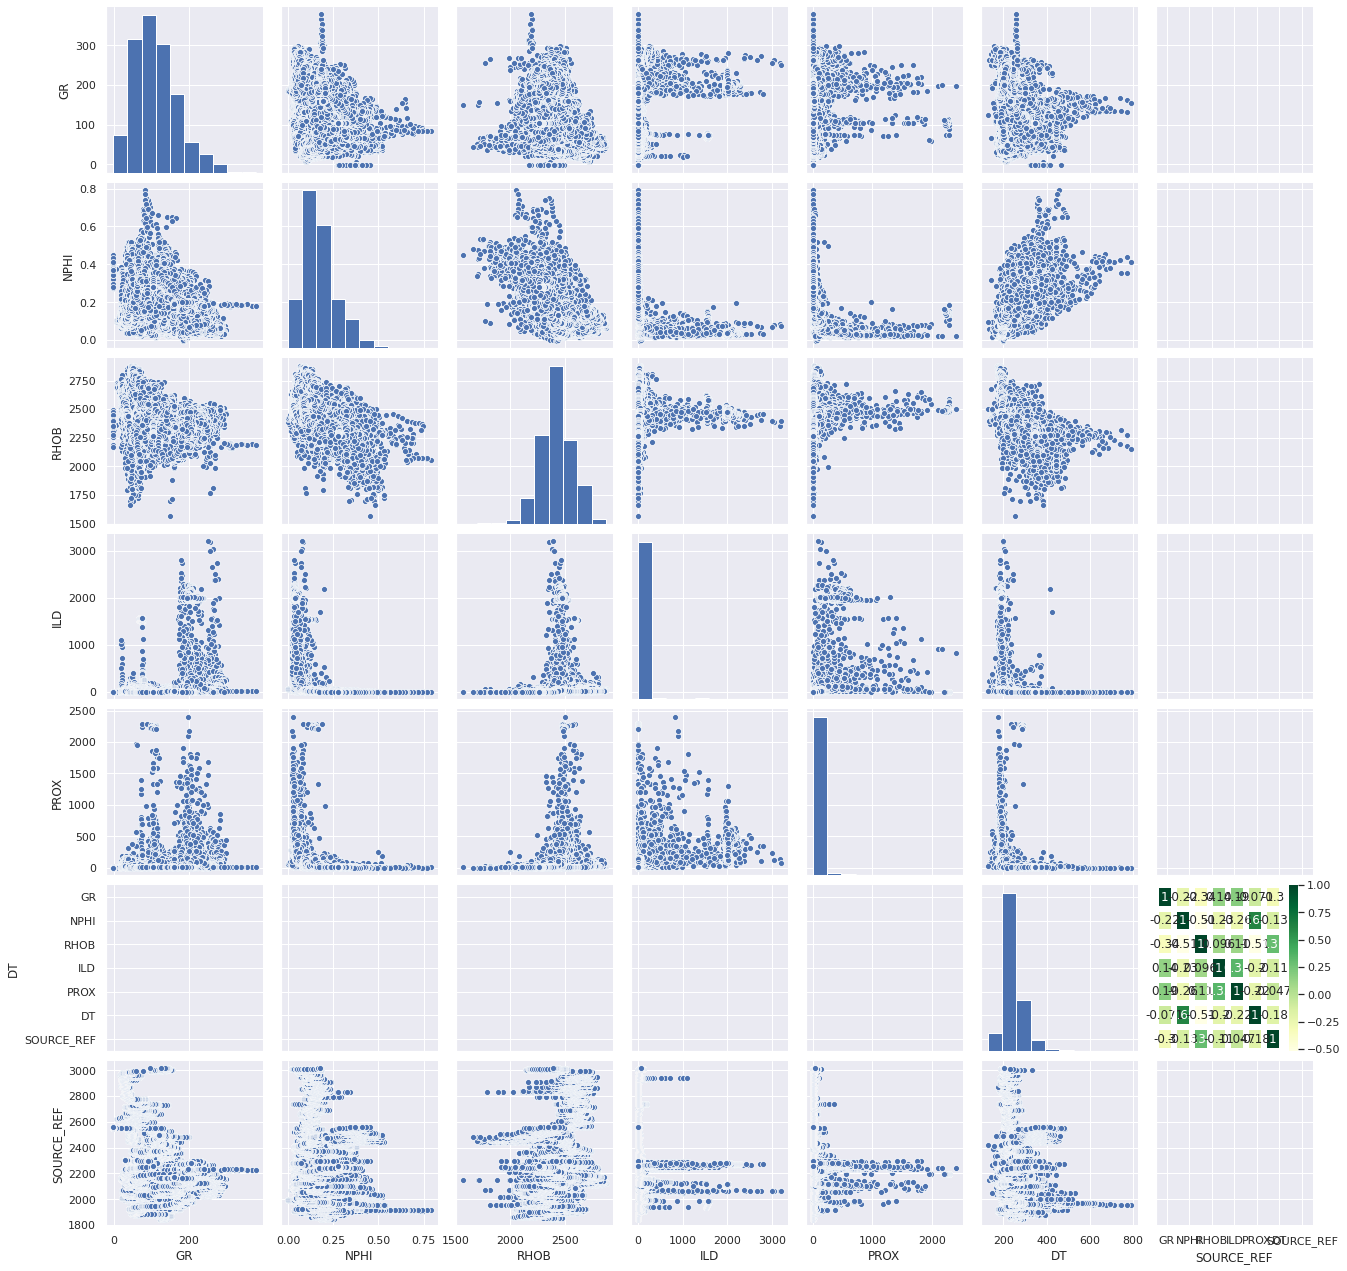

In [0]:
sns.set()
sns.pairplot(dset)

corr = dset.corr()
sns.heatmap(corr, cmap = 'YlGn', xticklabels=corr.columns,yticklabels=corr.columns, annot=True, linewidth = 5) 

####Preprocessing

In [0]:
dataset = dset[['SOURCE_REF','GR','NPHI','RHOB','ILD','PROX','DT']].copy()
db = dataset[dataset.index == 'JTB-118']
#db = pd.concat([db,dataset[dataset.index == 'JTB-080']],sort=False)
X = db.iloc[:,1:6]
Y = db.iloc[:,-1]
#Y = label_binarize(Y, classes=[0,1])

test = 0.20
seed = 0
batch = 500
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(X, Y, test_size=test, random_state=seed)

#scaler = MinMaxScaler()
#X_train = scaler.fit_transform(X_train)
#X_val = scaler.transform(X_val)

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

X_train = torch.from_numpy(X_train).float().to(device)
Y_train = torch.from_numpy(Y_train).to(device)
X_val = torch.from_numpy(X_val).float().to(device)
Y_val = torch.from_numpy(Y_val).to(device)

trainset = TensorDataset(X_train, Y_train)
trainloader = DataLoader(trainset, batch_size=batch, shuffle=True)

valset = TensorDataset(X_val, Y_val)
valloader = DataLoader(valset, batch_size=batch, shuffle=True)

print (Y_train)

###Model

In [0]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = nn.BatchNorm1d(7)
        self.hidden = nn.Linear(7, 5)
        self.output = nn.Linear(5, 2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.logsoftmax = nn.LogSoftmax()
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        x = self.norm(x)
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        x = self.logsoftmax(x)
        
        return x

In [0]:
def ModelSvr():
        classifier = SVR(kernel='linear')
        return classifier

def ModelLinear():
        classifier = SGDClassifier(loss='huber', penalty='elasticnet', verbose=1)
        return classifier
  
def ModelRF():
        classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1, verbose=1)
        return classifier

def ModelNBayes():
        classifier = GaussianNB()
        return classifier

###Train, test, predict

In [0]:
model = Network()
#model.cuda()
Xtrain, Ytrain = next(iter(trainloader))
Xval, Yval = next(iter(valloader))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr= 0.001)
epoch = 2000
loss_ = []
loss_test = []
for i in range(epoch):
    running_loss = 0
    runningloss_test = 0
    for Xtrain, Ytrain in trainloader:
        Ytrain = Ytrain.view(-1)
        optimizer.zero_grad()
        out = model(Xtrain)
        #print(out.shape)
        #print(Ytrain.shape)
        loss = criterion(out,Ytrain)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        Yval = Yval.view(-1)
        with torch.no_grad():
          logps = model(Xval)
        predict = torch.exp(logps).argmax(1)
        runningloss_test = criterion(logps,Yval).cpu().numpy()
        #loss_test += runningloss_test.item()
        print(f"Training loss: {running_loss/len(trainloader)}")
        print(f"Val loss: {runningloss_test/len(valloader)}")
        loss_test.append(runningloss_test/len(valloader))
        loss_.append(running_loss/len(trainloader))

In [0]:
classifier = ModelSvr()
classifier.fit(X_train, Y_train)
Y_predict = classifier.predict(X_val)

###History

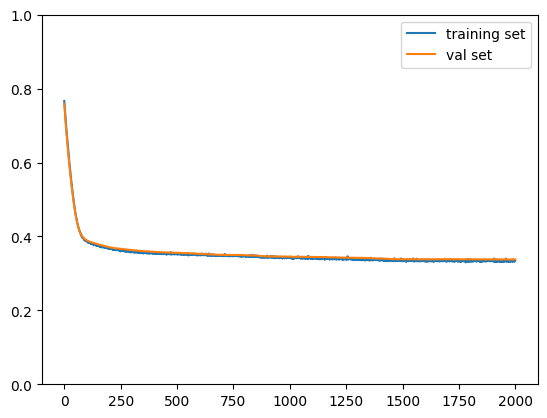

In [0]:
plt.plot(range(epoch),loss_,label="training set")
plt.plot(range(epoch),loss_test,label="val set")
plt.ylim([0,1])
plt.legend()

###Blind test

In [0]:
testset = dataset[dset.index == 'JTB-050'].dropna()
X_test = torch.Tensor(testset.iloc[:,1:6].values)
Y_test = torch.Tensor(testset.iloc[:,-1].values)
X_test = X_test.to(device)
Y_test = Y_test.to(device)
with torch.no_grad():
      logps = model(X_test)
predict = torch.exp(logps).cpu()
Y_predict = predict.numpy().flatten()
#Y_predict = predict.argmax(1)
print(Y_predict.shape)
testset['FRAC_PREDICT']=predict[:,1]

In [0]:
testset = dataset[dset.index == 'JTB-047'].dropna()
X_test = testset.iloc[:,1:6]
Y_test = testset.iloc[:,-1]
#X_test = scaler.transform(X_test)
Y_predict = classifier.predict(X_test)
#Y_predict = predict.argmax(1)
print(Y_predict.shape)
testset['DT_PREDICT']=Y_predict

(2059,)


####Visualize result

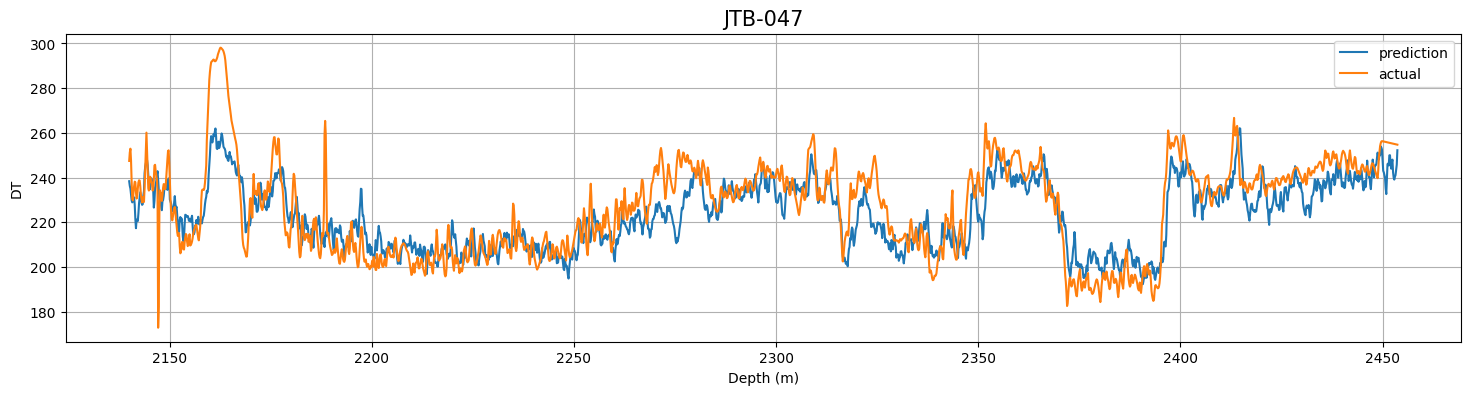

In [0]:
d = testset['SOURCE_REF']
plt.style.use('default')

fig = plt.gcf()
fig.set_size_inches(18, 4)
#fig.gca().invert_yaxis()
plt.tick_params(labelsize=10)
#plt.xlim([0,600])
plt.ylabel('DT',{'fontsize': 10, 'fontweight' : 5})
plt.xlabel('Depth (m)',{'fontsize': 10, 'fontweight' : 5})
plt.title(testset.index.any(),{'fontsize': 15, 'fontweight' : 5})
plt.plot(d,testset['DT_PREDICT'],label='prediction')
plt.plot(d,testset['DT'],label='actual')
plt.grid()
plt.legend()

####Accuracy

In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
mse_val = mean_squared_error(Y_predict,Y_test, squared=False)
mae_val = mean_absolute_error(Y_predict,Y_test)
variance_val = explained_variance_score(Y_predict,Y_test)
r2_val = r2_score(Y_predict,Y_test)
print('rmse= ',mse_val,'\nmae= ',mae_val,'\nvar= ',variance_val,'\nr2= ',r2_val)

rmse=  14.62605158085819 
mae=  11.309798572658467 
var=  0.2172459425237091 
r2=  0.16674848192949032


### Save model

In [0]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

from google.colab import drive
drive.mount('/content/gdrive')
model_save_name = 'model2604.pt'
path = F"/content/gdrive/My Drive/FracDet/{model_save_name}" 
torch.save(model.state_dict(), path)